# Predicting Obesity Using BMI Trajectories from EHR Data
##### By: Benji Wagner

This notebook aims to use weight, height, and other patient demographic information to answer the question: Can we use weight trajectories to predict obesity status of patients?

These EHRs are taken from a hospital database and is a child dataset (i.e. all patients in these tables are < 18 years old). I've purposely decided not to show any output out of concern of revealing patient-identifiable information. However, I wanted to demonstrate my ability to work with messy data rather than the usual clean datasets I tend to find on Kaggle or other sites.

### Reading Datasets

In [462]:
!ls /dcri/cpm/projects/Biostat824/DATA

ADDRESS.csv	     DEMOGRAPHICS.csv  LABS.csv			PAYOR.csv
DataDictionary.csv   DIAGNOSIS.csv     MEDS_PRESCRIBING.csv	PROCEDURES.csv
DataDictionary.xlsx  ENCOUNTER.csv     MEDS_RECONCILIATION.csv	VITALS.csv


In [461]:
from IPython.display import HTML

In [362]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegressionCV, LassoCV
from sklearn.metrics import roc_curve, roc_auc_score, confusion_matri
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier

Below is the data dictionary with all the variables as well as their table source listed

In [2]:
pd.read_csv("/dcri/cpm/projects/Biostat824/DATA/DataDictionary.csv")

,Unnamed: 0,Data Element,Source,Description
0,Shared Fields,PATID,NaN,Patient Identifier
1,NaN,ENCOUNTERID,NaN,Encounter Identifier
2,NaN,ADMIT_DATE,NaN,Date of Admission
3,NaN,DISCHARGE_DATE,NaN,Encounter Discharge Date
4,Unique Fields,ADDRESS_TYPE,ADDRESS,Mailing or Residence Address
5,NaN,PATADDR_EFFECTIVE_DATE,ADDRESS,Effective Start Date
6,NaN,PATTADDR_EXPIRATION_DATE,ADDRESS,Effective End Date
7,NaN,CITY,ADDRESS,City
8,NaN,COUNTY,ADDRESS,County
9,NaN,STATE,ADDRESS,State


In [3]:
vitals = pd.read_csv("/dcri/cpm/projects/Biostat824/DATA/VITALS.csv")
# Remove non-sense case of height
vitals = vitals[vitals.HT != 0]

`Vitals` contains the height and weight variables, which we are particularly interested in so we can calculate BMI. However, each row corresponds to a measurement and not to a unique patient. This means that even for a single visit, we may see one row with the patient ID and their height, another measurement from the same day/time with the patient ID and their blood pressure, etc. Thus, this data will need to be processed in order to consolidate information by patient as well as by visit date.

In [4]:
diagnosis = pd.read_csv("/dcri/cpm/projects/Biostat824/DATA/DIAGNOSIS.csv")

/opt/local/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py:2717: DtypeWarning: Columns (4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


### Data Pre-Processing

Define a simple function to convert height and weight to BMI

In [6]:
def calculate_bmi(height, weight):
    """calculate_bmi takes a height in inches and a weight in pounds, converts to meters and kilograms appropriately,
    and then calculates BMI"""
    return (weight/2.2046) / ((height/39.37)**2)

Convert measure_data to datetime so we can sort correctly

In [7]:
vitals[["MEASURE_DATE"]] = pd.to_datetime(vitals.MEASURE_DATE, format = "%d%b%Y:%H:%M:%S")

Drop rows without a height or weight measurement.

In [10]:
vitals = vitals.dropna(how = 'all', subset = ['HT', 'WT'])

For this analysis, we are not looking at blood pressure, so we're going to drop these columns

In [30]:
vitals = vitals.drop(labels = ["DIASTOLIC", "SYSTOLIC"], axis = 1)

We want patients who have at least one height measurement and one weight measurement
since we don't want to make assumptions about what their missing height/weight is
when imputing

In [41]:
valid_PATIDs = vitals.groupby("PATID").count()[(vitals.groupby("PATID").count().HT > 0) & (vitals.groupby("PATID").count().WT > 0)].index

In [44]:
vitals = vitals[vitals.PATID.isin(valid_PATIDs)]

Filter so that only obesity diagnoses obtained

In [27]:
obesity_table = diagnosis[(diagnosis.DX.str.startswith("E66", na = False)) | diagnosis.DX.str.startswith("278", na = False)]

Combine labels with vitals

In [97]:
vitals_obesity = obesity_table[['PATID', 'DX']].join(vitals.set_index('PATID'), how = 'right', on = "PATID")

Add obesity labels

Note: Instead of differentiating between levels of obesity, we are using a simple approach and just labeling them all as obese. If DX is missing, then these patients weren't diagnosed with obesity and get a negative label. Otherwise, they get a positive label.

In [98]:
vitals_obesity = vitals_obesity.assign(Obesity = np.repeat(1, vitals_obesity.shape[0]))
vitals_obesity.loc[vitals_obesity.DX.isnull(), "Obesity"] = 0
vitals_obesity = vitals_obesity.drop(labels = ["DX"], axis = 1)

Sort by Patient, then by Measure_Date

In [99]:
vitals_obesity.sort_values(by = ["PATID", "MEASURE_DATE"], inplace = True)

Consolidate height and weight measurements

In [100]:
vitals_obesity = vitals_obesity.groupby(["PATID", "MEASURE_DATE"]).mean().reset_index()

Interpolates missing values by using the values that it's bounded within, by patient.

Note: I had to group by the PATID values so that the resulting table wouldn't drop the PATID column

In [102]:
vitals_obesity = vitals_obesity.groupby(vitals_obesity.PATID.values).transform(lambda group: group.interpolate(limit_direction = "both"))

Even after using interpolation to fill in missing values, we still have 63464 missing values. This is because interpolate doesn't work for missing values on the boundaries. Therefore, we can fill in these missing values using backward fill followed by forward fill.

In [118]:
# Pad the missing values in the first/last visits
vitals_obesity.HT = vitals_obesity.groupby(vitals_obesity.PATID.values).HT.fillna(method = "bfill")
vitals_obesity.HT = vitals_obesity.groupby(vitals_obesity.PATID.values).HT.fillna(method = "ffill")
vitals_obesity.WT = vitals_obesity.groupby(vitals_obesity.PATID.values).WT.fillna(method = "bfill")
vitals_obesity.WT = vitals_obesity.groupby(vitals_obesity.PATID.values).WT.fillna(method = "ffill")

In [123]:
# Calculate BMI of each patient at each time
vitals_obesity["BMI"] = vitals_obesity.apply(lambda row: calculate_bmi(row['HT'], row['WT']), axis = 1)

### Checkpoint

In [124]:
vitals_obesity.to_pickle("/dcri/cpm/projects/Biostat824/USERS/Benji/output/vitals_obesity.pkl")

While there are a large number of options to handle the longitudinal nature of this data, I think the simplest method is to simply fit a polynomial curve to each patient's BMI, and then use the $\beta$ coefficients as predictors instead.

For this example, we will make a **strong** assumption by claiming that the BMI trajectories are linear.

We have 289320 patients with a calculated BMI. We have 207627 patients with more than one BMI measurement.

In [215]:
vitals_obesity = pd.read_pickle("/dcri/cpm/projects/Biostat824/USERS/Benji/output/vitals_obesity.pkl")

Now that we've done our pre-processing, it's time to attempt to use patient BMI trajectories as predictors.

In [216]:
repeated_patients = vitals_obesity.groupby("PATID").count()[(vitals_obesity.groupby("PATID").BMI.count() > 1)].index.values
vitals_obesity = vitals_obesity[vitals_obesity.PATID.isin(repeated_patients)]

Fit line to every patient's BMI's. Need at least two points.

In [158]:
intercept_slope = vitals_obesity.groupby("PATID").apply(lambda group: np.polyfit(pd.to_numeric(group.MEASURE_DATE), group.BMI, 1))

In [203]:
intercept_slope = intercept_slope.apply(pd.Series)
intercept_slope.columns = [["INTERCEPT", "SLOPE"]]

Now we have each patient's BMI intercept and slope, but we need to attach the obesity labels.

In [228]:
patient_df = pd.concat([intercept_slope.reset_index(), vitals_obesity.groupby("PATID").Obesity.mean().reset_index()], axis = 1)

In [248]:
# Drop duplicate PATID column
patient_df = patient_df.loc[:,~patient_df.columns.duplicated(keep='first')]

### Adding demographic information

In [229]:
demographics = pd.read_csv("/dcri/cpm/projects/Biostat824/DATA/DEMOGRAPHICS.csv")

In [230]:
demographics = demographics[(demographics.SEX == "F") | (demographics.SEX == "M")]

In [231]:
demographics = demographics[(demographics.RACE != "WHITE OR CAUCASIAN") & (demographics.RACE != "UNKNOWN")].drop("BIRTH_DATE", axis = 1)

In [255]:
patient_df = patient_df.join(other = demographics.set_index("PATID"), how = 'left', on = "PATID")

### Dummy-encode Categorical Variables

In [256]:
model_matrix = pd.concat([patient_df.drop(["SEX", "HISPANIC", "RACE"], axis = 1), pd.get_dummies(patient_df[["SEX", "HISPANIC", "RACE"]], drop_first = True)], axis = 1)

In [257]:
labels = model_matrix.Obesity.values

In [258]:
model_matrix = model_matrix.drop(["PATID", "Obesity"], axis = 1).values

### Train-Test Split

In [421]:
X_train, X_test, y_train, y_test = train_test_split(model_matrix, labels, stratify = labels, test_size=0.2, random_state = 2019)

Fit on unstandardized variables

### Logistic Regression Model

In [422]:
model = LogisticRegressionCV(cv = 10, penalty = "l2", solver = 'lbfgs', random_state = 2019).fit(X_train, y_train)

In [423]:
predicted_probs = model.predict_proba(X_test)
# first column = probability of observation being non-obese
# second column = probability of observation being obese

In [424]:
model.score(X_test, y_test)

0.94054327409333915

In [425]:
predictions = model.predict(X_test)

In [426]:
confusion_matrix(y_test, predictions)

array([[39057,     0],
       [ 2469,     0]])

In [427]:
model_auc_logistic = roc_auc_score(y_test, predicted_probs[:,1])

In [428]:
fpr_logistic, tpr_logistic, _ = roc_curve(y_test, predicted_probs[:, 1])

### Lasso Model

In [429]:
model = LassoCV(random_state = 2019, cv = 10).fit(X_train, y_train)

In [430]:
predicted_probs = model.predict(X_test)
# first column = probability of observation being non-obese
# second column = probability of observation being obese

In [431]:
model_auc_lasso = roc_auc_score(y_test, predicted_probs)
fpr_lasso, tpr_lasso, _ = roc_curve(y_test, predicted_probs)

### Random Forest

In [432]:
model = RandomForestClassifier(n_estimators = 300).fit(X_train, y_train)

In [433]:
predicted_probs = model.predict(X_test)
# first column = probability of observation being non-obese
# second column = probability of observation being obese

In [434]:
model.score(X_test, y_test)

0.89230843327072196

In [435]:
predictions = model.predict(X_test)

In [436]:
confusion_matrix(y_test, predictions)

array([[36819,  2238],
       [ 2234,   235]])

In [437]:
model_auc_forest = roc_auc_score(y_test, predicted_probs)

In [438]:
fpr_forest, tpr_forest, _ = roc_curve(y_test, predicted_probs)

#### ROC Curves

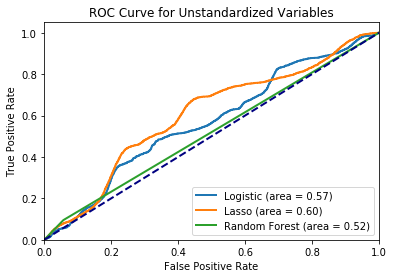

In [440]:
fig = plt.figure();
plt.plot(fpr_logistic, tpr_logistic, lw=2, label='Logistic (area = %0.2f)' % model_auc_logistic);
plt.plot(fpr_lasso, tpr_lasso, lw=2, label='Lasso (area = %0.2f)' % model_auc_lasso);
plt.plot(fpr_forest, tpr_forest, lw=2, label='Random Forest (area = %0.2f)' % model_auc_forest);
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--');
plt.xlim([0.0, 1.0]);
plt.ylim([0.0, 1.05]);
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('ROC Curve for Unstandardized Variables');
plt.legend(loc="lower right");
plt.show();

Our models didn't perform too well. I think this the class imbalance makes it diffifcult for our model to discriminate between obese and non-obese patients

## Standardized Variables

In [441]:
scaler = StandardScaler()

In [442]:
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

### Logistic Regression Model

In [443]:
model = LogisticRegressionCV(cv = 10, penalty = "l2", solver = 'lbfgs', random_state = 2019).fit(X_train, y_train)

In [444]:
predicted_probs = model.predict_proba(X_test)
# first column = probability of observation being non-obese
# second column = probability of observation being obese

In [445]:
predictions = model.predict(X_test,)

In [446]:
model.score(X_test, y_test)

0.94054327409333915

In [447]:
confusion_matrix(y_test, predictions)

array([[39057,     0],
       [ 2469,     0]])

In [448]:
model_auc_logistic = roc_auc_score(y_test, predicted_probs[:,1])

In [449]:
fpr_logistic, tpr_logistic, _ = roc_curve(y_test, predicted_probs[:, 1])

### Lasso Model

In [450]:
model = LassoCV(random_state = 2019, cv = 10).fit(X_train, y_train)

In [451]:
predicted_probs = model.predict(X_test)
# first column = probability of observation being non-obese
# second column = probability of observation being obese

In [452]:
model_auc_lasso = roc_auc_score(y_test, predicted_probs)
fpr_lasso, tpr_lasso, _ = roc_curve(y_test, predicted_probs)

### Random Forest

In [453]:
model = RandomForestClassifier(n_estimators = 300).fit(X_train, y_train)

In [454]:
predicted_probs = model.predict(X_test)
# first column = probability of observation being non-obese
# second column = probability of observation being obese

In [455]:
model.score(X_test, y_test)

0.93601598998217983

In [456]:
predictions = model.predict(X_test)

In [457]:
confusion_matrix(y_test, predictions)

array([[38340,   717],
       [ 1940,   529]])

In [458]:
model_auc_forest = roc_auc_score(y_test, predicted_probs)

In [459]:
fpr_forest, tpr_forest, _ = roc_curve(y_test, predicted_probs)

#### ROC Curves

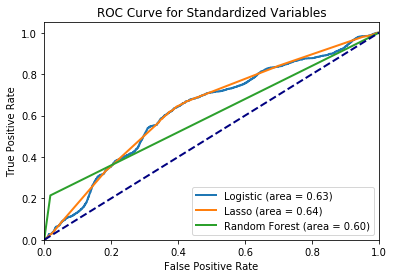

In [460]:
fig = plt.figure();
plt.plot(fpr_logistic, tpr_logistic, lw=2, label='Logistic (area = %0.2f)' % model_auc_logistic);
plt.plot(fpr_lasso, tpr_lasso, lw=2, label='Lasso (area = %0.2f)' % model_auc_lasso);
plt.plot(fpr_forest, tpr_forest, lw=2, label='Random Forest (area = %0.2f)' % model_auc_forest);
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--');
plt.xlim([0.0, 1.0]);
plt.ylim([0.0, 1.05]);
plt.xlabel('False Positive Rate');
plt.ylabel('True Positive Rate');
plt.title('ROC Curve for Standardized Variables');
plt.legend(loc="lower right");
plt.show();

Our models aren't able to discriminate the obese cases from the non-obese cases well. I conjecture that more data pre-processing needs to be done. For example, perhaps my assumption that the BMI trajectories are linear was incorrect. Perhaps the trajectories are non-linear, and I should go back and make these changes accordingly.

Additionally, the class imbalance may also be an issue. There are a lot more negative cases than positive cases (obese patients only account for < 6% of patients) so downsampling or other methods may need to be considered.

Another reason could be that we need to re-define our outcomes. The [CDC defines obesity](https://www.cdc.gov/healthyschools/obesity/facts.htm) in children and young people as BMI at or above the 95th percentile for young people of the same age and sex. 

If our models still do not perform well after these changes, one could argue that BMI trajectories may just be poor predictors for obesity.